# GSoC 2024 ML4SCI QMLHEP Task Submission

**Name:** Haemanth Velmurugan <br>
**Email:** haemanth10@gmail.com

### Task 5

### Quantum Graph Neural Network (QGNN) 
In task II you already worked with a classical GNN. 
* Describe a possibility for a QGNN circuit, which takes advantage of the graph representation of the data
* Implement and draw the circuit.

We shall use the ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/record/3164691#.YigdGt9MHrB) for this task as well. 

In [105]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import pennylane as qml
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

The main problem with Quantum GNNs is implementing message passing architecture. For the purposes of this task we use parameterized quantum circuits to learn node embeddings and PyTorch's classical Message passing interface to perform aggregation and complete the graph convolution step.

#### Parameterized quantum circuit to learn node embeddings

In [4]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def encoder(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layers of CZ and RY gates.
    """
    for i in range(0, nqubits - 1):  # Loop over even indices: i=0,2,...N-2
        qml.CZ(wires=[i, i + 1])

In [114]:
def quantum_net(n_qubits, q_depth):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum circuit.
        """

        # Reshape weights
        q_weights = q_weights_flat.reshape(q_depth, n_qubits)

        # Embed features in the quantum node
        encoder(inputs)

        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k])

        # Expectation values in the Z basis
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
        return exp_vals
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (q_depth*n_qubits)}), quantum_circuit

#### Visualizing the quantum layer

In [121]:
_, qc = quantum_net(5,2)
inputs = torch.randn(3)
params = torch.randn(5*2)
qml.draw(qc)(inputs, params)

'0: ──RX(-1.35)─╭●──RY(-1.47)────────────╭●──────────RY(-0.16)─────────────────────────────────┤  <Z>\n1: ──RX(0.51)──╰Z─╭●──────────RY(-0.86)─╰Z─────────╭●──────────RY(-2.19)──────────────────────┤  <Z>\n2: ──RX(-0.36)────╰Z─────────╭●──────────RY(-1.37)─╰Z─────────╭●──────────RY(1.24)────────────┤  <Z>\n3: ──────────────────────────╰Z─────────╭●──────────RY(2.06)──╰Z─────────╭●─────────RY(-1.20)─┤  <Z>\n4: ─────────────────────────────────────╰Z──────────RY(-0.42)────────────╰Z─────────RY(0.34)──┤  <Z>'

#### Hyperparameters

In [96]:
hidden_dims = 3
input_dims = 3
output_dims = 1
q_depth = 2
epochs = 20
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

#### Quantum-enhanced message passing neural network

In [107]:
class QGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(out_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
        
        self.qc = quantum_net(self.n_qubits, q_depth)

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        # Apply the quantum circuit to each element of the batch and append to q_out
#         q_out = torch.Tensor(0, self.n_qubits)
        
#         for xi in x:
#             q_out_elem = self.qc(xi).float().unsqueeze(0)
#             q_out = torch.cat((q_out, q_out_elem))

        q_out = self.qc(x).float().unsqueeze(0)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, q_out.size(0), dtype=q_out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=q_out, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [108]:
class QGCN(nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims):
        
        super().__init__()
        self.layers = [QGCNConv(input_dims, hidden_dims), QGCNConv(hidden_dims, hidden_dims)]
        self.activ_fn = ReLU()
        self.classifier = nn.Linear(hidden_dims, output_dims)

    def forward(self, x, edge_index, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

In [99]:
model = QGCN(input_dims, hidden_dims, output_dims)
model

QGCN(
  (activ_fn): ReLU()
  (classifier): Linear(in_features=3, out_features=1, bias=True)
)

#### Load the dataset

In [20]:
path = "C:/Users/HAEMANTH/Documents/Internships/GSoC/"

In [22]:
X = np.load(path+'x10_sorted_12500.npy')
y = np.load(path+'y10_sorted_12500.npy')

In [23]:
X = X[:,:,:3]
X.shape

(12500, 10, 3)

In [24]:
X[0, 0]

array([96.19041601,  1.76126124,  6.06750475])

In [25]:
X = torch.Tensor(X)

#### Normalize the dataset

In [26]:
torch.amax(X, dim=(0,1))

tensor([476.2361,   1.9953,   6.6201])

In [27]:
X_norm = X / torch.amax(X, dim=(0,1))   
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.

In [30]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(int(np.sqrt(M))+1, M)   # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1))
    
    for i,features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)
     
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [31]:
def create_graph_dataset(X, y):
    dataset = []
        
    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=yi)
        dataset.append(data)
        
    return dataset

In [32]:
dataset = create_graph_dataset(X_preprocessed,y)

In [33]:
len(dataset), dataset[0]

(12500, Data(x=[10, 3], edge_index=[2, 40], edge_attr=[40, 1], y=0.0))

In [72]:
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

In [97]:
train_dataloader = DataLoader(data_train,
                              batch_size = batch_size,
                              shuffle=True)
val_dataloader = DataLoader(data_val,
                            batch_size = batch_size,
                            shuffle=True)
test_dataloader = DataLoader(data_test,
                         batch_size = batch_size,
                         shuffle=True)

In [98]:
len(train_dataloader)

157

In [78]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True):
    if train:
        model.train()
    else:
        model.eval()
        
    loss = 0
    net_loss = 0
    correct = 0
  
    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):
        
        target = data.y

        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable 
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float()   
        # since we are working with logits and not probabilities (sigmoid is applied while computing loss), we consider 0 as threshold
        correct += (pred == target).sum()
        
        
    acc = 100. * correct / len(loader.dataset)
    net_loss /= len(loader.dataset)
      
    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")
        
    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          acc))
    
    return net_loss, acc

In [79]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
    return history    

In [100]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [55:06, 21.06s/it]


Train Epoch: 0 	Loss: 0.731651, Accuracy: 4938/10000 (49%)
Val Epoch: 0 	Loss: 0.722194, Accuracy: 650/1250 (52%)



157it [59:45, 22.84s/it]


Train Epoch: 1 	Loss: 0.713726, Accuracy: 4938/10000 (49%)
Val Epoch: 1 	Loss: 0.714193, Accuracy: 650/1250 (52%)



157it [41:11, 15.75s/it]


Train Epoch: 2 	Loss: 0.704268, Accuracy: 4938/10000 (49%)
Val Epoch: 2 	Loss: 0.710809, Accuracy: 650/1250 (52%)



157it [41:14, 15.76s/it]


Train Epoch: 3 	Loss: 0.699548, Accuracy: 4938/10000 (49%)
Val Epoch: 3 	Loss: 0.708784, Accuracy: 650/1250 (52%)



157it [1:17:34, 29.65s/it]


Train Epoch: 4 	Loss: 0.697695, Accuracy: 4938/10000 (49%)
Val Epoch: 4 	Loss: 0.709323, Accuracy: 650/1250 (52%)



157it [41:13, 15.76s/it]


Train Epoch: 5 	Loss: 0.696933, Accuracy: 4938/10000 (49%)
Val Epoch: 5 	Loss: 0.709566, Accuracy: 650/1250 (52%)



157it [41:09, 15.73s/it]


Train Epoch: 6 	Loss: 0.696717, Accuracy: 4627/10000 (46%)
Val Epoch: 6 	Loss: 0.709884, Accuracy: 583/1250 (47%)



157it [41:14, 15.76s/it]


Train Epoch: 7 	Loss: 0.696630, Accuracy: 4857/10000 (49%)
Val Epoch: 7 	Loss: 0.710133, Accuracy: 601/1250 (48%)



157it [41:13, 15.76s/it]


Train Epoch: 8 	Loss: 0.696620, Accuracy: 5048/10000 (50%)
Val Epoch: 8 	Loss: 0.710227, Accuracy: 600/1250 (48%)



157it [41:02, 15.69s/it]


Train Epoch: 9 	Loss: 0.696573, Accuracy: 5062/10000 (51%)
Val Epoch: 9 	Loss: 0.710221, Accuracy: 600/1250 (48%)



157it [41:17, 15.78s/it]


Train Epoch: 10 	Loss: 0.696552, Accuracy: 5062/10000 (51%)
Val Epoch: 10 	Loss: 0.710411, Accuracy: 600/1250 (48%)



157it [43:14, 16.52s/it]


Train Epoch: 11 	Loss: 0.696572, Accuracy: 5062/10000 (51%)
Val Epoch: 11 	Loss: 0.710491, Accuracy: 600/1250 (48%)



157it [1:14:39, 28.53s/it]


Train Epoch: 12 	Loss: 0.696568, Accuracy: 5062/10000 (51%)
Val Epoch: 12 	Loss: 0.710431, Accuracy: 600/1250 (48%)



157it [41:10, 15.74s/it]


Train Epoch: 13 	Loss: 0.696580, Accuracy: 5062/10000 (51%)
Val Epoch: 13 	Loss: 0.710277, Accuracy: 600/1250 (48%)



157it [40:52, 15.62s/it]


Train Epoch: 14 	Loss: 0.696561, Accuracy: 5062/10000 (51%)
Val Epoch: 14 	Loss: 0.710204, Accuracy: 600/1250 (48%)



157it [40:56, 15.65s/it]


Train Epoch: 15 	Loss: 0.696576, Accuracy: 5062/10000 (51%)
Val Epoch: 15 	Loss: 0.710368, Accuracy: 600/1250 (48%)



157it [40:49, 15.60s/it]


Train Epoch: 16 	Loss: 0.696562, Accuracy: 5062/10000 (51%)
Val Epoch: 16 	Loss: 0.710370, Accuracy: 600/1250 (48%)



157it [40:54, 15.63s/it]


Train Epoch: 17 	Loss: 0.696544, Accuracy: 5062/10000 (51%)
Val Epoch: 17 	Loss: 0.710327, Accuracy: 600/1250 (48%)



157it [40:48, 15.59s/it]


Train Epoch: 18 	Loss: 0.696543, Accuracy: 5062/10000 (51%)
Val Epoch: 18 	Loss: 0.710386, Accuracy: 600/1250 (48%)



157it [40:53, 15.63s/it]


Train Epoch: 19 	Loss: 0.696537, Accuracy: 5062/10000 (51%)
Val Epoch: 19 	Loss: 0.710393, Accuracy: 600/1250 (48%)



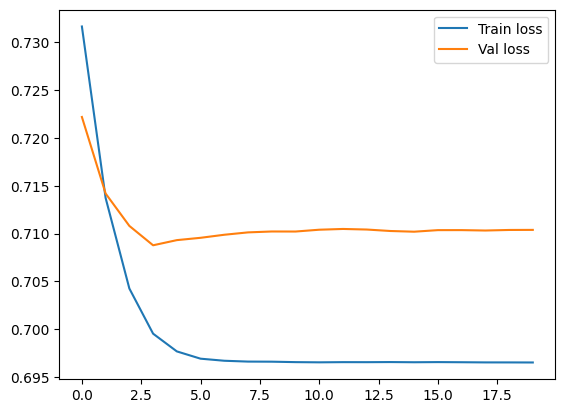

In [111]:
x = range(epochs)
plt.plot(x, history['train_loss'], label='Train loss')
plt.plot(x, history['val_loss'], label='Val loss')

plt.legend()
plt.show()

We have worked with a small subset of the Pythia8 dataset and trained a simple quantum ansatz for just 20 epochs. It can be infered from the graph that the loss follows a decreasing trend suggesting model learning. Further learning and employing better ansatz can produce much better results, which shall be explored as part of the project.